In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
import datetime
%matplotlib inline

In [2]:
# считывание данных из файла
data = pd.read_excel('/home/es/PycharmProjects/final/data/oil_names.xlsx', skiprows=1, index_col=0, na_values=['n.a.'])

# Расчет показателей (по Шеремету)
# вспомогательные показатели
net_assets = data['ass_all'] - data['obl_long'] - data['current_obl'] + data['reven_futur']
F_prime = data['fix_ass'] + data['ass_cur_deb']
E_c = net_assets - F_prime
C_d = data['obl_long']
E_d = E_c + C_d
C_kk = data['current_obl_loans'] + data['current_obl_contractor'] + data['obl_short']
E_o = E_d + C_kk
E_z = data['ass_cur_stock']
dE_c = E_c - E_z
dE_d = E_d - E_z
dE_o = E_o - E_z

# основные показатели
data['dE_c'] = dE_c
data['dE_d'] = dE_d
data['dE_o'] = dE_o

In [3]:
# отнесение компании к одной из категорий по расчитанным показателям
data['group'] = pd.Series(0, index=data.index)
data['group'].loc[data[(dE_c<0) & (dE_d<0) & (dE_o<0)].index] = 2
data['group'].loc[data[(dE_c<0) & (dE_d<0) & (dE_o>=0)].index] = 2
data['group'].loc[data[(dE_c<0) & (dE_d>=0) & (dE_o>=0)].index] = 1
data['group'].loc[data[(dE_c>=0) & (dE_d>=0) & (dE_o>=0)].index] = 1

/home/es/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
# отсеивание ошибочных данных
bad = (data['ass_all'] != data['passive']) | (data['obl_long'] < 0) | (data['current_obl'] < 0) | (data['reven_futur'] < 0) | (data['fix_ass'] < 0) | (data['ass_cur_deb'] < 0) | (data['current_obl_loans'] < 0) | (data['current_obl_contractor'] < 0) | (data['obl_short'] < 0) | (data['ass_cur_stock'] < 0) | (data['revenue'] <= 0)
data = data.drop(data[bad].index)
# удаление неинформативных признаков
data = data.drop('nc_ass_rev', 1)
data = data.drop('oth_oper', 1)

In [41]:
# подготовка данных
# названия столбцов ОПУ
pl_statement = ['revenue', 'net_cost', 'gross_profit', 'expen_realis', 'expen_adm', 'oper_profit', 'finoper_oth_inc', 'int_rec', 'int_pay', 'fin_oth_inc', 'exp_finoper_oth', 'prof_b_tax', 'tax_on_prof', 'unch_tax', 'def_tax_liab', 'def_tax_ass', 'other', 'prof_a_tax', 'prof_y']
X = data[pl_statement]
y = data['group']

classes = y.unique()
classes.sort(axis=0)
# разделение выборки на обучающую и проверочную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1580)

In [42]:
# Mr. Pasha proposed this method
X_train = pd.concat([X_train[y_train==2].head(122), X_train[y_train==1]])
y_train = pd.concat([y_train[y_train==2].head(122), y_train[y_train==1]])

In [43]:
def wac(est, X, y):
    w1 = 1
    w2 = 1
    ac1 = accuracy_score(y[y==1], est.predict(X[y==1]))
    ac2 = accuracy_score(y[y==2], est.predict(X[y==2]))
    return (ac1**w1) * (ac2**w2)

In [67]:
t1=datetime.datetime.now()
grid = {'max_features': np.arange(1, len(X.columns), 1), 'max_depth':np.arange(3, 5, 1), 'min_samples_leaf':np.arange(1, 20, 1)}
cv = KFold(y_train.size, n_folds=5, shuffle=True, random_state=1580)
# создание дерева
clf = tree.DecisionTreeClassifier(random_state=1580, criterion='entropy', class_weight='balanced')
gs = grid_search.GridSearchCV(clf, grid, scoring='accuracy', cv=cv, n_jobs=4)
gs.fit(X_train, y_train)
t2=datetime.datetime.now()

gs.best_params_

{'max_depth': 4, 'max_features': 18, 'min_samples_leaf': 19}

In [68]:
tr = gs.best_estimator_
# вычисление качества предсказания на обучающей выборке
print('accuracy (train):', accuracy_score(y_train, tr.predict(X_train)))
# предсказание с помощью обученного дерева
y_pred = tr.predict(X_test)
# вычисление качества предсказания на проверочной выборке
print('accuracy (test): ', accuracy_score(y_test, y_pred))
y_train_pred1 = tr.predict(X_train[data['group']==1])
y_train_pred2 = tr.predict(X_train[data['group']==2])
y_test_pred1 = tr.predict(X_test[data['group']==1])
y_test_pred2 = tr.predict(X_test[data['group']==2])

print('accuracy (train, class 1): ', accuracy_score(y_train[y_train==1], y_train_pred1))
print('accuracy (train, class 2): ', accuracy_score(y_train[y_train==2], y_train_pred2))
print('accuracy (test, class 1): ', accuracy_score(y_test[y_test==1], y_test_pred1))
print('accuracy (test, class 2): ', accuracy_score(y_test[y_test==2], y_test_pred2))

accuracy (train): 0.743169398907
accuracy (test):  0.573170731707
accuracy (train, class 1):  0.803278688525
accuracy (train, class 2):  0.713114754098
accuracy (test, class 1):  0.538461538462
accuracy (test, class 2):  0.589285714286


/home/es/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


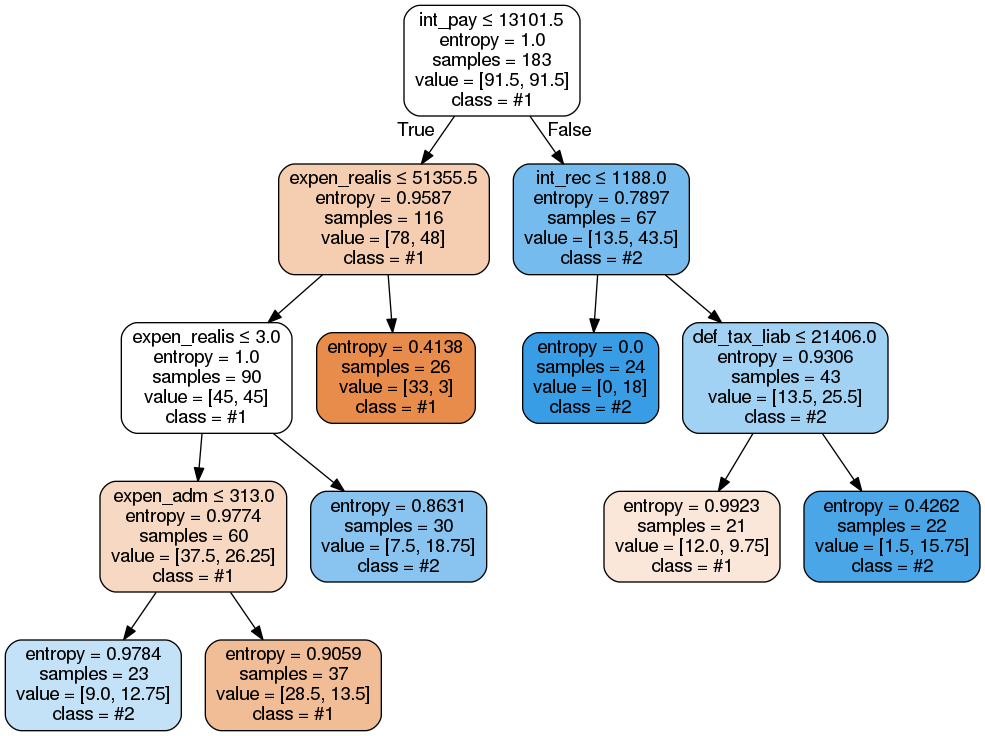

In [69]:
from sklearn.externals.six import StringIO
import pydotplus
dot_data = StringIO()
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(tr, out_file=dot_data, feature_names=list(X_train.columns), class_names=['#'+str(cl) for cl in classes], filled=True, rounded=True, special_characters=True)  
graphs = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graphs.create_png())

In [36]:
grid = {'C': np.arange(2, 16.0, 0.1)}
cv = KFold(y_train.size, n_folds=5, shuffle=True, random_state=1580)
# создание логистической регрессии
clf = LogisticRegression(random_state=1580)
gs = grid_search.GridSearchCV(clf, grid, scoring='accuracy', cv=cv, n_jobs=4)
gs.fit(X_train, y_train)

gs.best_params_

{'C': 5.5000000000000036}

In [37]:
lr = gs.best_estimator_
# вычисление качества предсказания на обучающей выборке
print('accuracy (train):', accuracy_score(y_train, lr.predict(X_train)))
# предсказание с помощью обученного дерева
y_pred = lr.predict(X_test)
# вычисление качества предсказания на проверочной выборке
print('accuracy (test): ', accuracy_score(y_test, y_pred))
y_train_pred1 = lr.predict(X_train[data['group']==1])
y_train_pred2 = lr.predict(X_train[data['group']==2])
y_test_pred1 = lr.predict(X_test[data['group']==1])
y_test_pred2 = lr.predict(X_test[data['group']==2])

print('accuracy (train, class 1): ', accuracy_score(y_train[y_train==1], y_train_pred1))
print('accuracy (train, class 2): ', accuracy_score(y_train[y_train==2], y_train_pred2))
print('accuracy (test, class 1): ', accuracy_score(y_test[y_test==1], y_test_pred1))
print('accuracy (test, class 2): ', accuracy_score(y_test[y_test==2], y_test_pred2))

accuracy (train): 0.775956284153
accuracy (test):  0.743902439024
accuracy (train, class 1):  0.475409836066
accuracy (train, class 2):  0.926229508197
accuracy (test, class 1):  0.576923076923
accuracy (test, class 2):  0.821428571429


/home/es/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [38]:
len(lr.predict(X_test)[lr.predict(X_test)==tr.predict(X_test)])

63

In [39]:
len(X_test)

82

In [40]:
63/82

0.7682926829268293